In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn
import quimb as qu
import cotengra as ctg
import autoray as ar
from time_compressed_algo import register_ as reg
from time_compressed_algo import algo_cooling as algo
from time_compressed_algo import quf
import time
import numpy as np
from quimb.tensor.belief_propagation.l2bp import L2BP
from tqdm import tqdm


In [2]:
reg.reg_complex_svd()
import torch
to_backend = algo.backend_torch(device = "cuda", dtype = torch.complex128, requires_grad=False)
to_backend_c = algo.backend_torch(device = "cuda", dtype = torch.complex128, requires_grad=False)

opt = algo.opt_(progbar=True)

In [3]:
#ITF params
J = 1
h = 3.05
delta = 0.05

In [4]:
Lx, Ly = 4, 4
L = Lx * Ly
edges = qtn.edges_2d_square(Lx=Lx, Ly=Ly, cyclic=False)

sites = sorted({ (site,) for edge in edges for site in edge})
N = len(sites)
N

16

In [5]:
# mpo = quf.mpo_ITF_2d(Lx, Ly, data_type="float64", chi=200, cutoff_val=1.0e-12, field=h, sign="-", print_=False)

In [6]:
Harr_params = [ quf.random_haar_qubit(seed=1)   for i in range(L)]
peps = quf.peps_haar(Lx=Lx, Ly=Ly, dtype="complex128", Harr_params = Harr_params)
peps.apply_to_arrays(to_backend)


In [7]:
# norm_ = (peps.H & peps).contract(all, optimize=opt)
# norm_

In [8]:
pepo_t = quf.pepo_trotter_ITF(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=delta)
pepo_t

PEPO(tensors=16, indices=56, Lx=4, Ly=4, max_bond=2)

In [9]:
%%time
chi = 4
pepo = pepo_t.copy()

Infidelity_l = []
Infidelity_bp_l = []
Error_l = []
Error_norm_bp = []
Error_norm = []
Norm_l = []
depth_total = 20
pbar = tqdm(total=depth_total - 1, desc="BP:", ncols=100, dynamic_ncols=True)

t = delta
t_l = []
norm = 1.
for step in range(depth_total - 1):
    t += delta
    peps = algo.apply_peps(peps, pepo_t, flat=True)
    peps_raw = peps.copy()
    #print(step, "bond", peps_raw.max_bond())
    bp = L2BP(peps, site_tags=list(pepo.site_tags), damping=0.0, optimize=opt, 
              normalize = 'L2phased', update='parallel',
             )
    bp.run(tol=1.e-7, max_iterations=2000, progbar=False, diis = True)
    peps = bp.compress(peps, max_bond=chi, cutoff=1.-12, cutoff_mode="rsum2", renorm=0, lazy=False)
    
    mantissa, norm_exponent = bp.contract(strip_exponent=True)
    est_norm = complex(mantissa * 10**norm_exponent)
    print("bp_norm", est_norm.real)
    Infidelity_bp_l.append(est_norm.real)
    Error_norm_bp.append( 1 - est_norm.real  )

    # print("check",  complex((peps_raw.H & peps_raw).contract(all, optimize=opt)).real, complex(norm).real)

    
    chi_ = 120
    copt = algo.copt_(progbar=True, chi=chi_, directory=None, max_repeats=2**9)
    # f = quf.loss_peps(peps, peps_raw, opt, copt, cost_f="fid", val_=norm, chi_bmps=chi_, mode = "exact", progbar=False)
    # f_ = quf.loss_peps_g(peps, peps_raw, opt, copt, cost_f="fid", chi_bmps=chi_, mode = "exact", progbar=False)
    
    norm = quf.peps_norm(peps, opt=opt, copt=copt, chi=chi_, mode = "exact",
            max_separation=1, 
            sequence = ['xmin', 'xmax', 'ymin', 'ymax'],
            progbar=False,
            )
    # Norm_l.append(complex(norm).real)
    # Infidelity_l.append(1 - complex(f).real)
    # t_l.append(t)    
    print("norm", complex(norm).real)
    # Error_l.append( 1 - np.prod(Infidelity_l) )
    # Error_norm.append( 1 - complex(norm).real  )
    # print("t", t, "f", 1 - complex(f).real, 1 - complex(f_).real, np.prod(Infidelity_l), Error_l[-1])
    pbar.set_postfix({
            "norm": f"{est_norm.real:.4e}",
        })
    pbar.update(1)


BP::   5%|████                                                                         | 1/19 [00:00<00:02,  6.28it/s, norm=1.0000e+00]

bp_norm 0.9999999999999976
norm 1.000000000000007
bp_norm 1.0000000000000078


BP::  11%|████████                                                                     | 2/19 [00:00<00:03,  5.46it/s, norm=1.0000e+00]

norm 0.999999999999997


BP::  16%|████████████▏                                                                | 3/19 [00:00<00:03,  4.35it/s, norm=1.0000e+00]

bp_norm 0.9999999999999957
norm 0.9999992292300669


BP::  21%|████████████████▏                                                            | 4/19 [00:00<00:03,  3.85it/s, norm=1.0000e+00]

bp_norm 0.9999999999991326
norm 0.9999917326027223


BP::  26%|████████████████████▎                                                        | 5/19 [00:01<00:03,  3.61it/s, norm=1.0000e+00]

bp_norm 0.9999999999193648
norm 0.9999564368549764


BP::  32%|████████████████████████▎                                                    | 6/19 [00:01<00:03,  3.27it/s, norm=1.0000e+00]

bp_norm 0.9999999981046986
norm 0.9998439816938208


BP::  37%|████████████████████████████▎                                                | 7/19 [00:02<00:03,  3.01it/s, norm=1.0000e+00]

bp_norm 0.9999999778553275
norm 0.9995598789138879


BP::  42%|████████████████████████████████▍                                            | 8/19 [00:02<00:03,  2.77it/s, norm=1.0000e+00]

bp_norm 0.9999998260277371
norm 0.9989292136608943


BP::  47%|████████████████████████████████████▍                                        | 9/19 [00:02<00:03,  2.63it/s, norm=1.0000e+00]

bp_norm 0.9999989179339757
norm 0.9976023063487723


BP::  53%|████████████████████████████████████████                                    | 10/19 [00:03<00:03,  2.45it/s, norm=9.9999e-01]

bp_norm 0.9999942109680369
norm 0.9948367532291179


BP::  58%|████████████████████████████████████████████                                | 11/19 [00:03<00:03,  2.26it/s, norm=9.9997e-01]

bp_norm 0.9999724169573175
norm 0.9891131243235244


BP::  63%|████████████████████████████████████████████████                            | 12/19 [00:04<00:03,  2.09it/s, norm=9.9988e-01]

bp_norm 0.999881509280203
norm 0.9775405735496157


BP::  68%|████████████████████████████████████████████████████                        | 13/19 [00:05<00:03,  1.91it/s, norm=9.9954e-01]

bp_norm 0.9995392804774357
norm 0.9542795352320947


BP::  74%|████████████████████████████████████████████████████████                    | 14/19 [00:05<00:02,  1.75it/s, norm=9.9839e-01]

bp_norm 0.9983858188404946
norm 0.9083457290771335


BP::  79%|████████████████████████████████████████████████████████████                | 15/19 [00:06<00:02,  1.57it/s, norm=9.9512e-01]

bp_norm 0.9951176206898117
norm 0.8496948167571664


BP::  84%|████████████████████████████████████████████████████████████████            | 16/19 [00:07<00:02,  1.40it/s, norm=9.9070e-01]

bp_norm 0.9907047233225267
norm 0.8031658144444996


BP::  89%|████████████████████████████████████████████████████████████████████        | 17/19 [00:08<00:01,  1.31it/s, norm=9.8947e-01]

bp_norm 0.9894710247993102
norm 0.8097012760792849


BP::  95%|████████████████████████████████████████████████████████████████████████    | 18/19 [00:09<00:00,  1.27it/s, norm=9.8819e-01]

bp_norm 0.9881939127792564
norm 0.8314065308650735


BP:: 100%|████████████████████████████████████████████████████████████████████████████| 19/19 [00:09<00:00,  1.23it/s, norm=9.8684e-01]

bp_norm 0.98683590643136
norm 0.8455697528247832
CPU times: user 9.98 s, sys: 41.4 ms, total: 10 s
Wall time: 9.99 s


In [10]:
est_norm

(0.98683590643136+1.3220866104277063e-16j)

In [11]:
Error_l

[]

ValueError: x and y must have same first dimension, but have shapes (0,) and (19,)

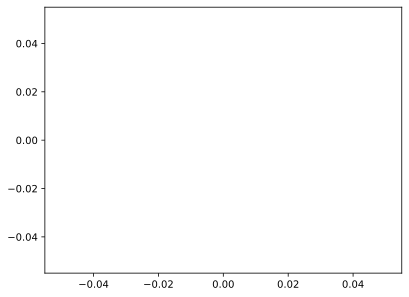

In [12]:
import matplotlib.pyplot as plt

Error_norm = [ abs(i) for i in Error_norm ]

# qu.save_to_disk(Error_l, f"store/Error_l_peps{chi}")
# qu.save_to_disk(Error_norm_bp, f"store/Error_l_pepsbp{chi}")
# qu.save_to_disk(Error_norm, f"store/Error_norm_peps{chi}")
# qu.save_to_disk(t_l, f"store/t_l")


plt.plot(
    t_l, Error_l, zorder=5, label=r"infidelity, $\chi=8$",
    markersize=10, linewidth=2.7, alpha=1., marker='o', linestyle='-',
    markeredgecolor="whitesmoke", mfc="darkred", markeredgewidth=1.4
)

plt.plot(
    t_l, Error_norm, zorder=5, label=r"Norm, $\chi=8$",
    markersize=10, linewidth=2.7, alpha=1., marker='o', linestyle='-',
    markeredgecolor="whitesmoke", mfc="darkred", markeredgewidth=1.4
)

plt.plot(
    t_l, Error_norm_bp, zorder=5, label=r"bp-infidelity, $\chi=8$",
    markersize=10, linewidth=2.7, alpha=1., marker='o', linestyle='-',
    markeredgecolor="whitesmoke", mfc="darkred", markeredgewidth=1.4
)

plt.yscale('log')

# Set axis limits
plt.xlim(0, max(t_l))        # adjust x-axis range if needed
# plt.ylim(1e-1, 1.2)            # adjust y-axis range for log scale

plt.ylabel("Fidelity Metric", fontsize=12)
plt.xlabel("time", fontsize=12)

plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.5)
plt.tick_params(width=0.8, labelsize=12)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.)

plt.title(rf"$L = {Lx} \times {Ly}$, $\delta={delta}$", fontsize=14, color='darkred', pad=15)  # pad adds space above the plot

plt.grid(color='gray', linestyle='-', linewidth=1., alpha=1.)
plt.legend(loc='best', frameon=True, shadow=True, fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:

pepo.show()

In [ ]:
pepo

In [ ]:
# qu.save_to_disk(pepo, "store/pepo")

In [ ]:

tn_ = pepo.copy()
bp = L2BP(tn_, site_tags=list(pepo.site_tags), damping=0.0, optimize=opt, 
          normalize = 'L2phased', update='parallel',
         )
bp.run(tol=1.e-7, max_iterations=2000, progbar=True, diis = True)
pepo_guess = bp.compress(tn_, max_bond=chi, cutoff=1.-12, cutoff_mode="rsum2", renorm=0, lazy=False)

mantissa, norm_exponent = bp.contract(strip_exponent=True)
est_norm = complex(mantissa * 10**norm_exponent)
print(est_norm)

In [ ]:
# tn_ = pepo.copy()
# tn_.compress_all(inplace=True, **{"max_bond":8, "canonize_distance":4, "cutoff":1e-14})


In [ ]:
# (tn_.H & tn_).contract(all, optimize=opt)

In [ ]:
%%time
chi = 128
copt = algo.copt_(progbar=True, chi=chi, directory=None, max_repeats=2**9)
quf.loss_peps(tn_, pepo, opt, copt, "fid", (2.)**(L), chi_bmps=chi, mode = "mps")

In [ ]:

tnopt = qtn.TNOptimizer(
    tn_,                       
    quf.loss_peps,
    loss_constants = {"peps_fix":pepo},
    loss_kwargs = {'opt': opt, 'cost_f': "fid", "val_": (2.)**(L), "chi_bmps":chi, "mode": "mps", "copt":copt},
    autodiff_backend = "torch",
    optimizer= "L-BFGS-B", #'L-BFGS-B',
    progbar=True, jit_fn=True, device="cuda",
    #shared_tags=tags_opt,
)






In [ ]:
tn_ = tnopt.optimize_nlopt(n=220, ftol_abs=2.220e-10, xtol_abs=2.220e-10)

